# Analysis of genomic data using NLP tools

This notebook contains non AI algorithms to try to understand the main features of genomic sequences of Hemagglutinin. In particular it verifies that the proprieties of genomic sequences of Hemagglutinin in different hosts have different structure language wise

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm
import itertools


## Data and preanalysis

In [30]:
from Bio import SeqIO
import re
#Data
records = list(SeqIO.parse("./ird_influenzaA_HA_allspecies.fa", "fasta"))
print(records[0])

def extract_host(description):
    # Regular expression to match the host information
    match = re.search(r'Host:([^|]+)', description)
    if match:
        return match.group(1).strip()
    return None

ID: gb:K00429|ncbiId:AAR96248.1|UniProtKB:Q6LEJ4|Organism:Influenza
Name: gb:K00429|ncbiId:AAR96248.1|UniProtKB:Q6LEJ4|Organism:Influenza
Description: gb:K00429|ncbiId:AAR96248.1|UniProtKB:Q6LEJ4|Organism:Influenza A virus (A/seal/Mass/1/1980(H7N7))|Strain Name:A/seal/Mass/1/1980|Protein Name:HA Hemagglutinin|Gene Symbol:HA|Segment:4|Subtype:H7N7|Host:Sea Mammal
Number of features: 0
Seq('MNTQILVFIACVLIEAKGDKICLGHHAVANGTKVNTLTERGIEVVNATETVETA...ICI')


In [31]:
#Params

n = 3 #lenght of the n_grams

############AOOOOOOOOOOOOOOOOO
#PRIMA DI MODIFICARE IL CODICE PENSACI BENE!
#porcoddio tienilo basso che ti sei gia' fottuto il computer 10 volte
reduced_records = records[:5000] #modify for smaller dataset
############AOOOOOOOOOOOOOOOOO


In [32]:
#The implementation of this function can be done with sovraposition or without
def n_gram_maker(sequence, n):
    return [sequence[i:i+n] for i in range(0, len(sequence) - n + 1, 3)]

In [33]:
sequences = []
for record in tqdm(reduced_records):
    seq = str(record.seq)
    label = extract_host(record.description)
    sequences.append((label, seq))


100%|██████████| 5000/5000 [00:00<00:00, 138281.66it/s]


In [34]:

datasets = defaultdict(list)
for label, seq in sequences:
    datasets[label].append(seq)

data = pd.DataFrame(sequences, columns=["Host", "Sequence"])
for i in range(3, 4):
    data[f"{i}_grams"] = data["Sequence"].apply(n_gram_maker, args=(n := i,)) #grazie pandas per questa sintassi ritardata

In [35]:
min_occ = 100
max_occ = 1000

host_counts = data['Host'].value_counts()
hosts_more_than_50_entries = host_counts[(host_counts > min_occ) & (host_counts < max_occ)].index.tolist()
filtered_data = data[data['Host'].isin(hosts_more_than_50_entries)].reset_index(drop=True)

filtered_data = filtered_data[filtered_data.Host != "Unknown"]
filtered_hosts = filtered_data['Host'].unique()
print("Hosts with more than 50 entries:")
print(filtered_hosts)

filtered_data


Hosts with more than 50 entries:
['American Black Duck' 'Green-Winged Teal' 'American Green-Winged Teal'
 'American Wigeon']


,Host,Sequence,3_grams
0,American Black Duck,MYKIVLAFALLGAVNGLDKICLGHHAVSNGTIVKTLTSEKEEVTNA...,"[MYK, IVL, AFA, LLG, AVN, GLD, KIC, LGH, HAV, ..."
1,American Black Duck,MEAKLFVLFCTFTVLKADTICVGYHANNSTDTVDTVLEKNVTVTHS...,"[MEA, KLF, VLF, CTF, TVL, KAD, TIC, VGY, HAN, ..."
2,American Black Duck,MLSITILFLLIAEVSSQNYTGNPVICLGHHAVPNGTMVKTLTDDQI...,"[MLS, ITI, LFL, LIA, EVS, SQN, YTG, NPV, ICL, ..."
3,American Black Duck,MKTVIALSYIFCLAFGQNLPGNDNSTATLCLGHHAVPNGTIVKTIT...,"[MKT, VIA, LSY, IFC, LAF, GQN, LPG, NDN, STA, ..."
4,American Black Duck,MNTQILALIACMLIGAKGDKICLGHHAVANGTKVNTLTERGIEVVN...,"[MNT, QIL, ALI, ACM, LIG, AKG, DKI, CLG, HHA, ..."
...,...,...,...
642,Green-Winged Teal,MLSITILFLLIAESSSQNYTGNPVICLGHHAVSNGTMVKTLTDDQV...,"[MLS, ITI, LFL, LIA, ESS, SQN, YTG, NPV, ICL, ..."
643,Green-Winged Teal,MLSITILFLLIAEISSQNYTGNPVICLGHHAVPNGTMVKTLTDDQI...,"[MLS, ITI, LFL, LIA, EIS, SQN, YTG, NPV, ICL, ..."
644,American Black Duck,MEAKLFVLFCTFTVLKADTICVGYHANNSTDTVDTVLEKNVTVTHS...,"[MEA, KLF, VLF, CTF, TVL, KAD, TIC, VGY, HAN, ..."
645,American Black Duck,MIAIIVIAILAAAGKSDKICIGYHANNSTTQVDTILEKNVTVTHSV...,"[MIA, IIV, IAI, LAA, AGK, SDK, ICI, GYH, ANN, ..."


# Analysis

## Counting occurrences

In [36]:
species_pairs = {}

for species in filtered_hosts:
    pairs = {}

    species_data = filtered_data[filtered_data["Host"] == species]["3_grams"] #STO ULTIMO PARAMETRO E' PER RIUSCIRE A FARE I CONTI BENE
    for basket in tqdm(species_data, desc=f"Processing {species}"):
        basket_pairs = list(itertools.combinations(basket, 2))
        for pair in basket_pairs[:]:
            basket_pairs.append(pair[::-1])

        for pair in basket_pairs:
            pairs[pair] = pairs.get(pair, 0) + 1
species_pairs[species] = pairs


## To visualize but kinda fucked up
#for species, pairs in species_pairs.items():
#    print(f"Results for {species}:")
#    for pair, count in pairs.items():
#        print(f"Pair {pair} appears {count} times.")

Processing American Black Duck:   4%|▍         | 10/225 [00:00<00:10, 20.38it/s]

Processing American Wigeon: 100%|██████████| 105/105 [00:06<00:00, 15.62it/s]


In [37]:
import itertools

transitions = defaultdict(Counter)

for species in filtered_hosts:

    species_data = filtered_data[filtered_data["Host"] == species]["3_grams"]#STO ULTIMO PARAMETRO E' PER RIUSCIRE A FARE I CONTI BENE
    for basket in tqdm(species_data, desc=f"Processing {species}"):
        for i in range(len(basket) - 1):
            transitions[basket[i]][basket[i + 1]] += 1

print(transitions)

Processing American Wigeon: 100%|██████████| 105/105 [00:00<00:00, 6518.29it/s]

defaultdict(<class 'collections.Counter'>, {'MYK': Counter({'IVL': 33, 'IIL': 2}), 'IVL': Counter({'VLA': 28, 'LLA': 9, 'VFA': 3, 'LFA': 2, 'AFA': 1, 'ILA': 1}), 'AFA': Counter({'LNK': 43, 'LLG': 1}), 'LLG': Counter({'FIM': 123, 'AVH': 31, 'NPE': 9, 'GKE': 3, 'AVD': 2, 'AVN': 1, 'AVY': 1, 'FII': 1}), 'AVN': Counter({'GQR': 74, 'GMC': 3, 'GLD': 1, 'SQR': 1}), 'GLD': Counter({'KIC': 35}), 'KIC': Counter({'TQG': 73, 'LGH': 35, 'IGY': 7, 'TKG': 3, 'TRG': 1}), 'LGH': Counter({'HAV': 204, 'HAI': 3, 'PLI': 2}), 'HAV': Counter({'PNG': 170, 'SNG': 34}), 'SNG': Counter({'SMQ': 77, 'NFI': 49, 'SLQ': 43, 'TIV': 33, 'AFL': 24, 'SCR': 3, 'NEY': 2, 'TVV': 1, 'NAY': 1, 'NFL': 1}), 'TIV': Counter({'KTI': 164, 'KTL': 35, 'KPG': 22, 'LSY': 5, 'RPG': 1, 'KTV': 1, 'KAG': 1}), 'KTL': Counter({'TNE': 33, 'DLH': 24, 'ENC': 8, 'DEH': 8, 'TSE': 1, 'TNK': 1, 'EDC': 1}), 'TSE': Counter({'QQS': 41, 'KEE': 1}), 'KEE': Counter({'VTN': 34, 'VTS': 1}), 'VTN': Counter({'ATE': 205, 'GTK': 1}), 'ATE': Counter({'LVQ': 172

## TF IDF


TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a statistical measure used to evaluate the importance of a word or phrase (in this case, 3-grams) in a document relative to a collection of documents (corpus). It is widely used in information retrieval and text mining.

### Components of TF-IDF

1. **Term Frequency (TF)**:
    - **Definition**: The number of times a term (word or phrase) appears in a document.
    - **Calculation**: \( \text{TF}_{i,j} = \frac{\text{Number of times term } t_i \text{ appears in document } d_j}{\text{Total number of terms in document } d_j} \)
    - **Purpose**: Measures how frequently a term occurs in a document.

2. **Inverse Document Frequency (IDF)**:
    - **Definition**: A measure of how much information the word provides, that is, whether the term is common or rare across all documents.
    - **Calculation**: \( \text{IDF}_{i} = \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing the term } t_i} \right) \)
    - **Purpose**: Measures how significant a term is within the entire corpus. Rare terms across documents get higher IDF scores.

3. **TF-IDF Score**:
    - **Definition**: The product of TF and IDF scores for a term.
    - **Calculation**: \( \text{TF-IDF}_{i,j} = \text{TF}_{i,j} \times \text{IDF}_i \)
    - **Purpose**: Balances the term frequency with its importance by scaling up rare terms and scaling down common terms.

### Application of TF-IDF in the Code

The provided code applies the TF-IDF technique to analyze and compare the importance of 3-grams (sequences of three words) across different host species in a dataset. Here’s a breakdown of the process:

1. **Data Preparation**:
    - Convert lists of 3-grams into strings for vectorization.
    - Group the data by the host species.

2. **TF-IDF Calculation**:
    - For each species (host), initialize a TF-IDF Vectorizer without converting the text to lowercase (to maintain case sensitivity).
    - Compute the TF-IDF matrix for the 3-grams strings.
    - Extract the feature names (3-grams) and their corresponding TF-IDF scores.
    - Sum the TF-IDF scores for each 3-gram across all documents in the group.
    - Store the results in a DataFrame and sort them by the TF-IDF scores in descending order.

3. **Result Display**:
    - Display the top 10 3-grams with the highest TF-IDF scores for each species.

### Interpretation

The higher the TF-IDF score of a 3-gram for a particular host species, the more important that 3-gram is considered within the documents related to that species, compared to the entire corpus. By observing difference in TF IDF scores ranking in different host we can already see that there is a difference


In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


df = pd.DataFrame(filtered_data)

# Convert lists of 3-grams into strings for vectorization
df['3_grams_str'] = df['3_grams'].apply(lambda x: ' '.join(x))

# Group by Host (species)
grouped = df.groupby('Host')

# Initialize a dictionary to store TF-IDF results for each species
tfidf_results = {}

# Calculate TF-IDF for each species
for host, group in grouped:
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(lowercase=False)
    
    # Compute TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(group['3_grams_str'])
    
    # Extract feature names (3-grams)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum TF-IDF scores for each 3-gram across all documents
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    tfidf_scores_df = pd.DataFrame({'3_gram': feature_names, 'tfidf_score': tfidf_scores})
    
    # Sort by TF-IDF score in descending order
    sorted_tfidf_scores_df = tfidf_scores_df.sort_values(by='tfidf_score', ascending=False)
    
    # Store the sorted TF-IDF scores DataFrame in the results dictionary
    tfidf_results[host] = sorted_tfidf_scores_df

# Display the top 10 3-grams for each species
for host, tfidf_df in tfidf_results.items():
    print(f"Top 10 3-grams for {host}:\n", tfidf_df.head(10), "\n")


Top 10 3-grams for American Black Duck:
      3_gram  tfidf_score
453     GRI    11.489403
833     LVA    11.436288
929     NGK    11.284996
162     DKG     8.928138
1275    SIS     8.826005
65      ASG     8.267664
1138    QTS     7.917885
1315    SRP     7.671401
1511    VKQ     7.661896
1230    RVT     7.644214 

Top 10 3-grams for American Green-Winged Teal:
      3_gram  tfidf_score
66      ASG     6.031337
920     NGK     5.310233
450     GRI     5.209562
829     LVA     5.145908
463     GSS     4.598822
905     NDN     4.561438
1087    QIL     4.385581
546     IEN     4.336996
530     IAP     4.269657
507     HHP     4.241589 

Top 10 3-grams for American Wigeon:
      3_gram  tfidf_score
502     IES     6.642654
730     LNK     6.465207
448     GYH     5.934490
486     ICI     4.067143
674     LAT     4.047149
417     GRI     3.524406
1229    SSS     3.437025
668     KYV     3.426655
97      CPY     3.417380
239     EKN     3.417380 

Top 10 3-grams for Green-Winged Teal:
     

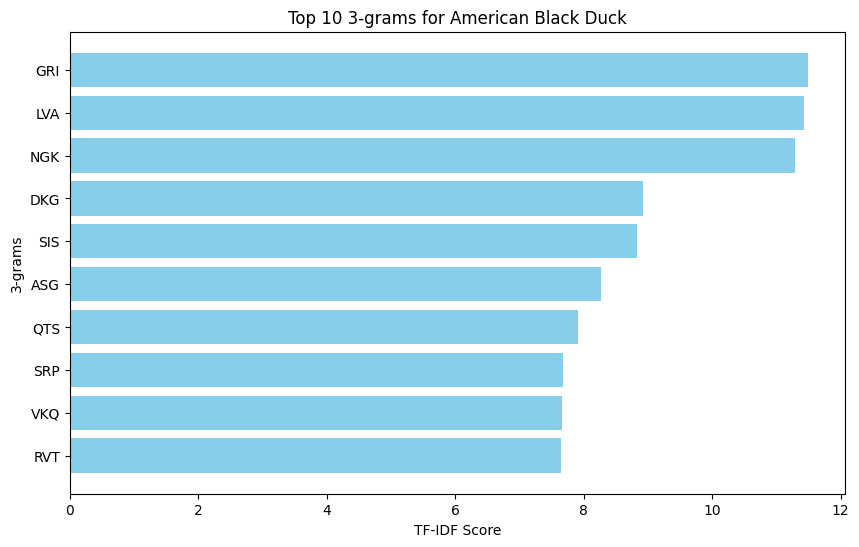

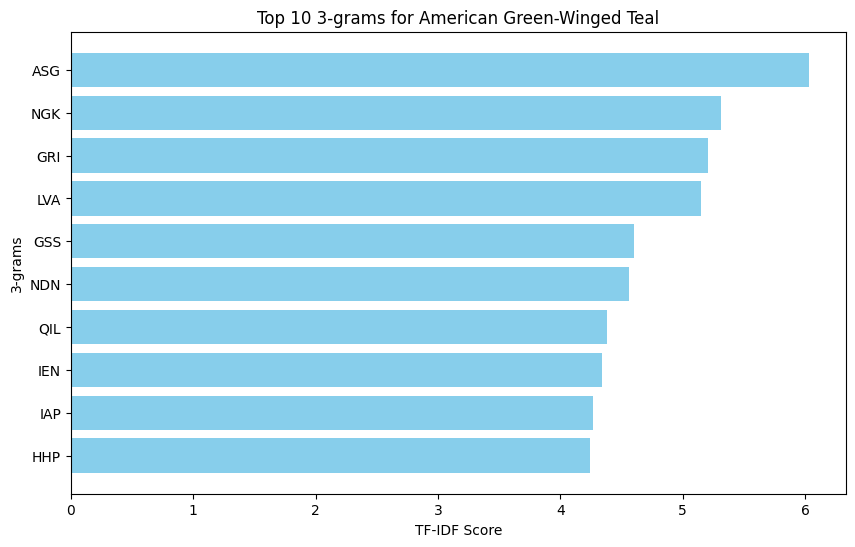

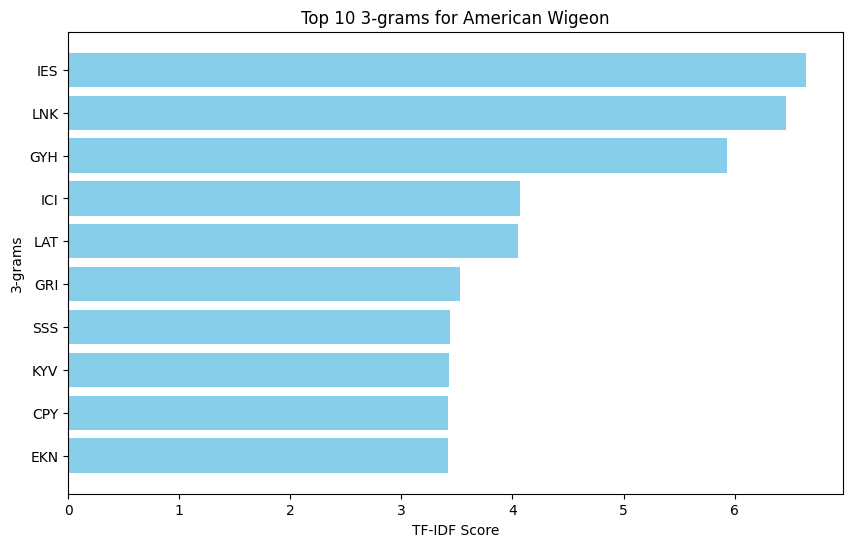

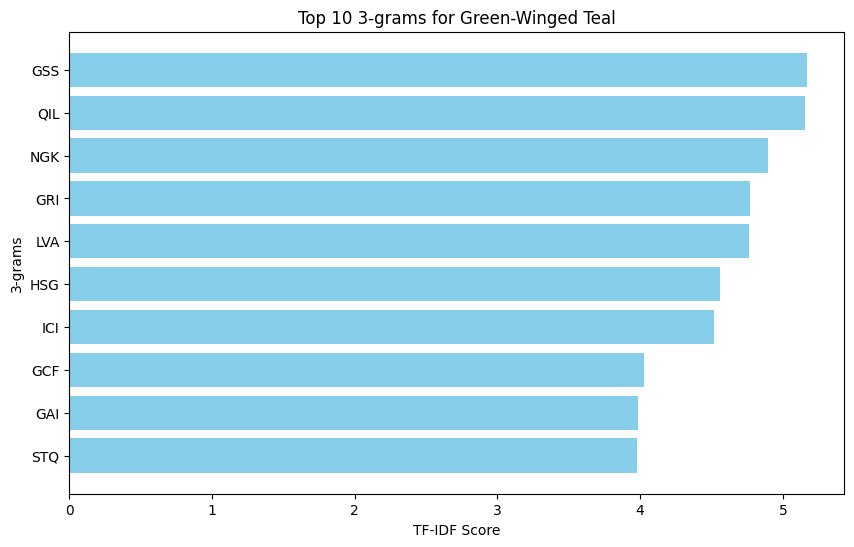

In [39]:
## Visualize the top 10 3-grams for each host
#for host, tfidf_df in tfidf_results.items():
#    # Get the top 10 3-grams and their scores
#    top_10_df = tfidf_df.head(10)
#    
#    # Create bar chart
#    plt.figure(figsize=(10, 6))
#    plt.barh(top_10_df['3_gram'], top_10_df['tfidf_score'], color='skyblue')
#    plt.xlabel('TF-IDF Score')
#    plt.ylabel('3-grams')
#    plt.title(f'Top 10 3-grams for {host}')
#    plt.gca().invert_yaxis()
#    plt.show()

# Analysis using matrices


In [58]:
transition_matrices = {}

for species in tqdm(filtered_hosts):
    pairs = {}

    # Extract and concatenate the 3-grams for the current species
    species_data = filtered_data[filtered_data["Host"] == species]["3_grams"].values
    concat_data = np.concatenate(species_data)
    
    if len(concat_data) == 0:
        # Skip species with no data
        print(f"No data available for species: {species}")
        continue

    # Identify unique states and initialize transition matrix
    unique_states = sorted(set(concat_data))
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    # Count transitions
    for (current_state, next_state) in zip(concat_data[:-1], concat_data[1:]):
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize to get probabilities
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = transition_matrix.div(row_sums, axis=1).fillna(0)  # Handle division by zero
    
    # Store the transition matrix in the dictionary
    transition_matrices[species] = transition_matrix

    #print(f"Transition Matrix for species: {species}")
    #print(transition_matrix)


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:00<00:00, 15.24s/it]


In [66]:
# Choose a subset of rows to display
for key in transition_matrices[filtered_hosts[0]].index[:20]:
    non_null_states = []
    for i in  transition_matrices[filtered_hosts[0]][key]:
        if i != 0:
            non_null_states.append(i)
    print(non_null_states)

[1.0]
[0.896551724137931, 0.10344827586206896]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[0.35135135135135137, 0.527027027027027, 0.12162162162162163]
[0.18181818181818182, 0.8181818181818182]
[0.5, 0.5]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]
[1.0]


In [42]:
import matplotlib.pyplot as plt

# Flatten the transition matrix and filter out zeros
for species in filtered_hosts:
    values = species_pairs[species].values.flatten()
    non_zero_values = values[values > 0]
    print(non_zero_values)

    ## Plot histogram
    #plt.figure(figsize=(5, 4))
    #plt.hist(non_zero_values, bins=len(non_zero_values), edgecolor='k', alpha=0.7)
    #plt.title(f'Histogram of Transition Probabilities for {species}')
    #plt.xlabel('Probability')
    #plt.ylabel('Frequency')
    #plt.show()


KeyError: 'American Black Duck'